In [218]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [219]:
np.set_printoptions(precision=3, suppress=True)

In [220]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

2.4.1


# The Auto MPG dataset

## 데이터 불러오기

In [221]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
"""
na_values: 결측치 처리
comment: 

"""

'\nna_values: 결측치 처리\ncomment: \n\n'

## 데이터 전처리

In [222]:
# Dataframe 복사 및 확인
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [223]:
# 결측치 확인
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [224]:
#결측치 제거
dataset = dataset.dropna()

In [225]:
# 범주형 데이터 변환
dataset['Origin'] = dataset['Origin'].map({1:'USA', 2: 'Europe', 3:'Japan'})

In [226]:
# 원핫인코딩
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [227]:
# 데이터셋 분리
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)


In [228]:
test_dataset.shape

(78, 10)

In [229]:
train_dataset.shape

(314, 10)

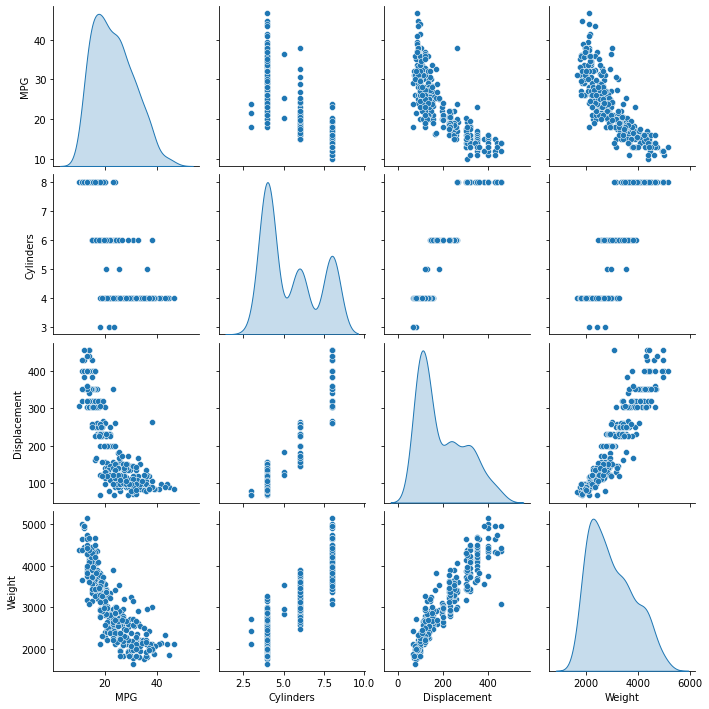

In [230]:
# pairplot으로 상관관계 확인
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [153]:
# 통계치 확인
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [231]:
# feature, label 분리
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# 정규화

In [232]:
# mean, std 확인 -> feature별로 값들의 차이가 커 학습을 효율적으로 하기 위해서는 정규화가 필요하다
train_dataset.describe().transpose()[['mean','std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [233]:
# normalizer 생성
normalizer = preprocessing.Normalization(axis=-1)

In [234]:
# normalizer 적용
normalizer.adapt(np.array(train_features))

In [235]:
# 각 feature에 대한 평균
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [236]:
train_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [237]:
# 첫번째 인덱스의 features
first = np.array(train_features[:1])

# 원본값과 정규화 이후의 값들 비교
with np.printoptions(precision=2, suppress=True):
    print('First example', first)
    print()
    print('Normalized', normalizer(first).numpy())

First example [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Linear Regression

In [238]:
# Horsepower 정규화
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape = [1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [239]:
# 정규화 후 linear layer 1개로 구성된 모델
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])
horsepower_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [240]:
# 모델을 통해 예측
horsepower_model.predict(horsepower[:10])

array([[ 0.931],
       [ 0.526],
       [-1.718],
       [ 1.304],
       [ 1.18 ],
       [ 0.463],
       [ 1.398],
       [ 1.18 ],
       [ 0.307],
       [ 0.526]], dtype=float32)

In [241]:
# optimizer, loss 설정
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [242]:
# model에 돌린 결과 저장
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: user 9.75 s, sys: 246 ms, total: 10 s
Wall time: 9.46 s


In [243]:
# 결과 출력
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802140,4.195970,95
96,3.802633,4.192729,96
97,3.803471,4.185474,97
98,3.803732,4.168856,98
99,3.803010,4.183904,99


In [244]:
# loss 그래프 함수
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)


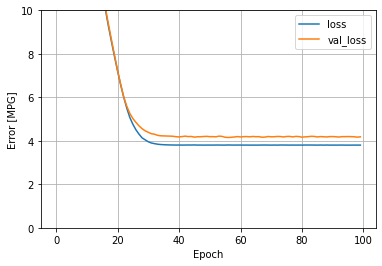

In [245]:
plot_loss(history)

In [246]:
# test의 loss
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)
test_results

{'horsepower_model': 3.6485259532928467}

In [247]:
# x는 0~250까지의 수
# y는 예측값
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [248]:
# 산점도 그리기 함수
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

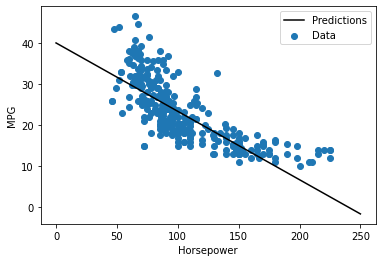

In [249]:
plot_horsepower(x,y)

## Multiple inputs

In [250]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [251]:
# 10개의 샘플 예측
linear_model.predict(train_features[:10])

array([[ 1.204],
       [-0.208],
       [-1.374],
       [ 1.164],
       [ 2.083],
       [-0.493],
       [ 2.118],
       [-2.283],
       [-0.148],
       [ 1.6  ]], dtype=float32)

In [252]:
linear_model.layers[1].kernel

<tf.Variable 'dense_23/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.267],
       [-0.528],
       [-0.501],
       [-0.364],
       [-0.605],
       [-0.036],
       [-0.493],
       [ 0.607],
       [-0.054]], dtype=float32)>

In [253]:
# optimizer, loss 설정
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [254]:
# 학습하여 loss 저장
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: user 10 s, sys: 281 ms, total: 10.3 s
Wall time: 9.7 s


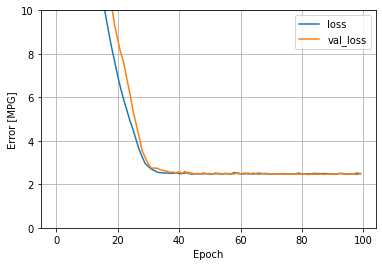

In [255]:
# loss 그리기
plot_loss(history)

In [256]:
# test_loss 저장
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# A DNN regression

In [257]:
# 모델, 컴파일 만들기
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [258]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [259]:
dnn_horsepower_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [260]:
# 학습시켜서 loss 저장(Horsepower로만)
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 10.4 s, sys: 383 ms, total: 10.8 s
Wall time: 9.9 s


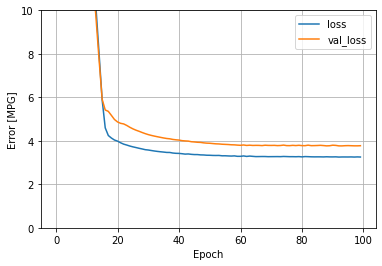

In [261]:
# loss 그리기
plot_loss(history)

In [262]:
# x:0~250에 대한 예측
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

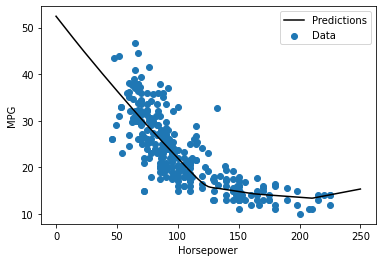

In [263]:
# 시각화
plot_horsepower(x, y)

In [264]:
# test loss 저장
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)
test_results

{'horsepower_model': 3.6485259532928467,
 'linear_model': 2.5535647869110107,
 'dnn_horsepower_model': 2.9050660133361816}

## Full model

In [265]:
# 모델 만들기
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_27 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [266]:
# 학습시켜서 loss 저장(전체 feature 이용)
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 11 s, sys: 406 ms, total: 11.4 s
Wall time: 10.4 s


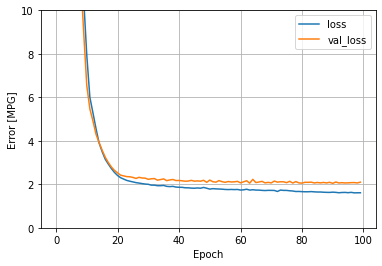

In [267]:
plot_loss(history)

In [268]:
# test loss 저장 
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results

{'horsepower_model': 3.6485259532928467,
 'linear_model': 2.5535647869110107,
 'dnn_horsepower_model': 2.9050660133361816,
 'dnn_model': 1.6430106163024902}

# Performance

In [269]:
# 딕셔너리에 저장된 loss 데이터프레임으로 나타내기
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648526
linear_model,2.553565
dnn_horsepower_model,2.905066
dnn_model,1.643011


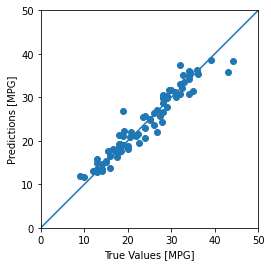

In [270]:
# 예측값과 실제 라벨의 산점도
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

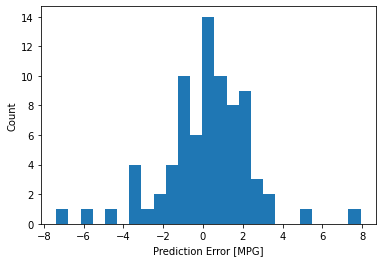

In [271]:
# 오차의 히스토그램
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [273]:
# 모델 저장
dnn_model.save('dnn_model')

In [274]:
# 모델 불러오기
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [275]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648526
linear_model,2.553565
dnn_horsepower_model,2.905066
dnn_model,1.643011
reloaded,1.643011
